In [1]:
import pandas as pd

# basic feature extraction
import preprocess_kgptalkie as ps
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# save model
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('twitter_sentiment.csv', header=None, index_col=[0])

In [3]:
df.head()

,1,2,3
0,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
df.isnull().sum()

sentiment      0
text         686
dtype: int64

In [7]:
# Drop missing values
df.dropna(inplace=True)

In [8]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [9]:
df = df[df['text'].apply(len)>1]

In [10]:
df.shape

(74647, 2)

In [11]:
df['sentiment'].value_counts()

sentiment
Negative      22530
Positive      20844
Neutral       18285
Irrelevant    12988
Name: count, dtype: int64

In [12]:
def apply_basic_features(df, text_col):
    df['char_counts'] = df[text_col].apply(ps.char_count)
    df['word_counts'] = df[text_col].apply(ps.word_count)
    df['avg_word_length'] = df[text_col].apply(ps.avg_word_len)
    df['stop_words_count'] = df[text_col].apply(ps.stop_words_count)
    df['hashtags_count'] = df[text_col].apply(ps.hashtags_count)
    df['mentions_count'] = df[text_col].apply(ps.mentions_count)
    df['numerics_count'] = df[text_col].apply(ps.numerics_count)
    df['upper_case_count'] = df[text_col].apply(ps.upper_case_count)
    return df

In [13]:
df = apply_basic_features(df, 'text')

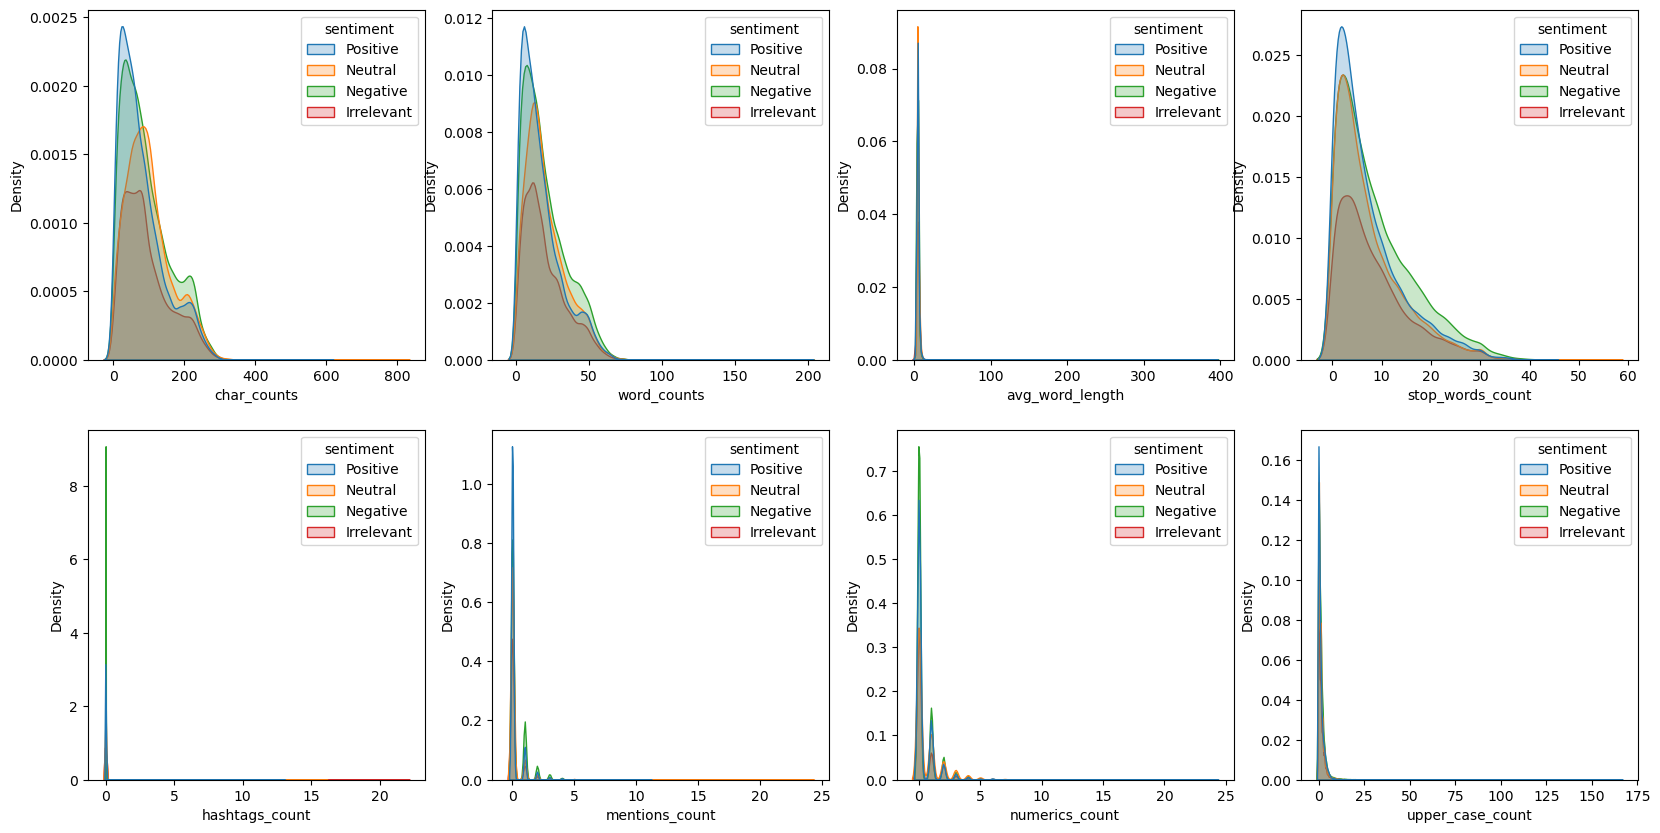

In [14]:
# plot 2x4 grid histogram for each numerical feature
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.subplot(2,4, num_cols.get_loc(col)+1)

    # use sentiment as hue to see the distribution of each numerical feature
    # sns.distplot(df[col], label=col, color='red')
    # sns.histplot(x=col, hue='sentiment', data=df, color='green', bins=100, kde=True)
    sns.kdeplot(data=df, x=col, hue='sentiment', fill=True)

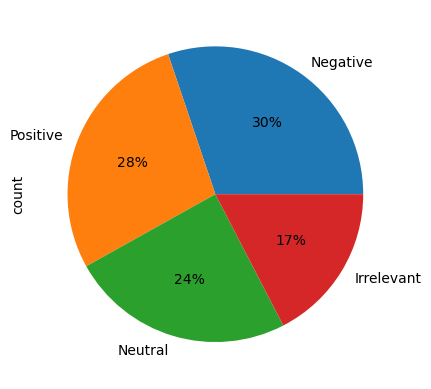

In [15]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

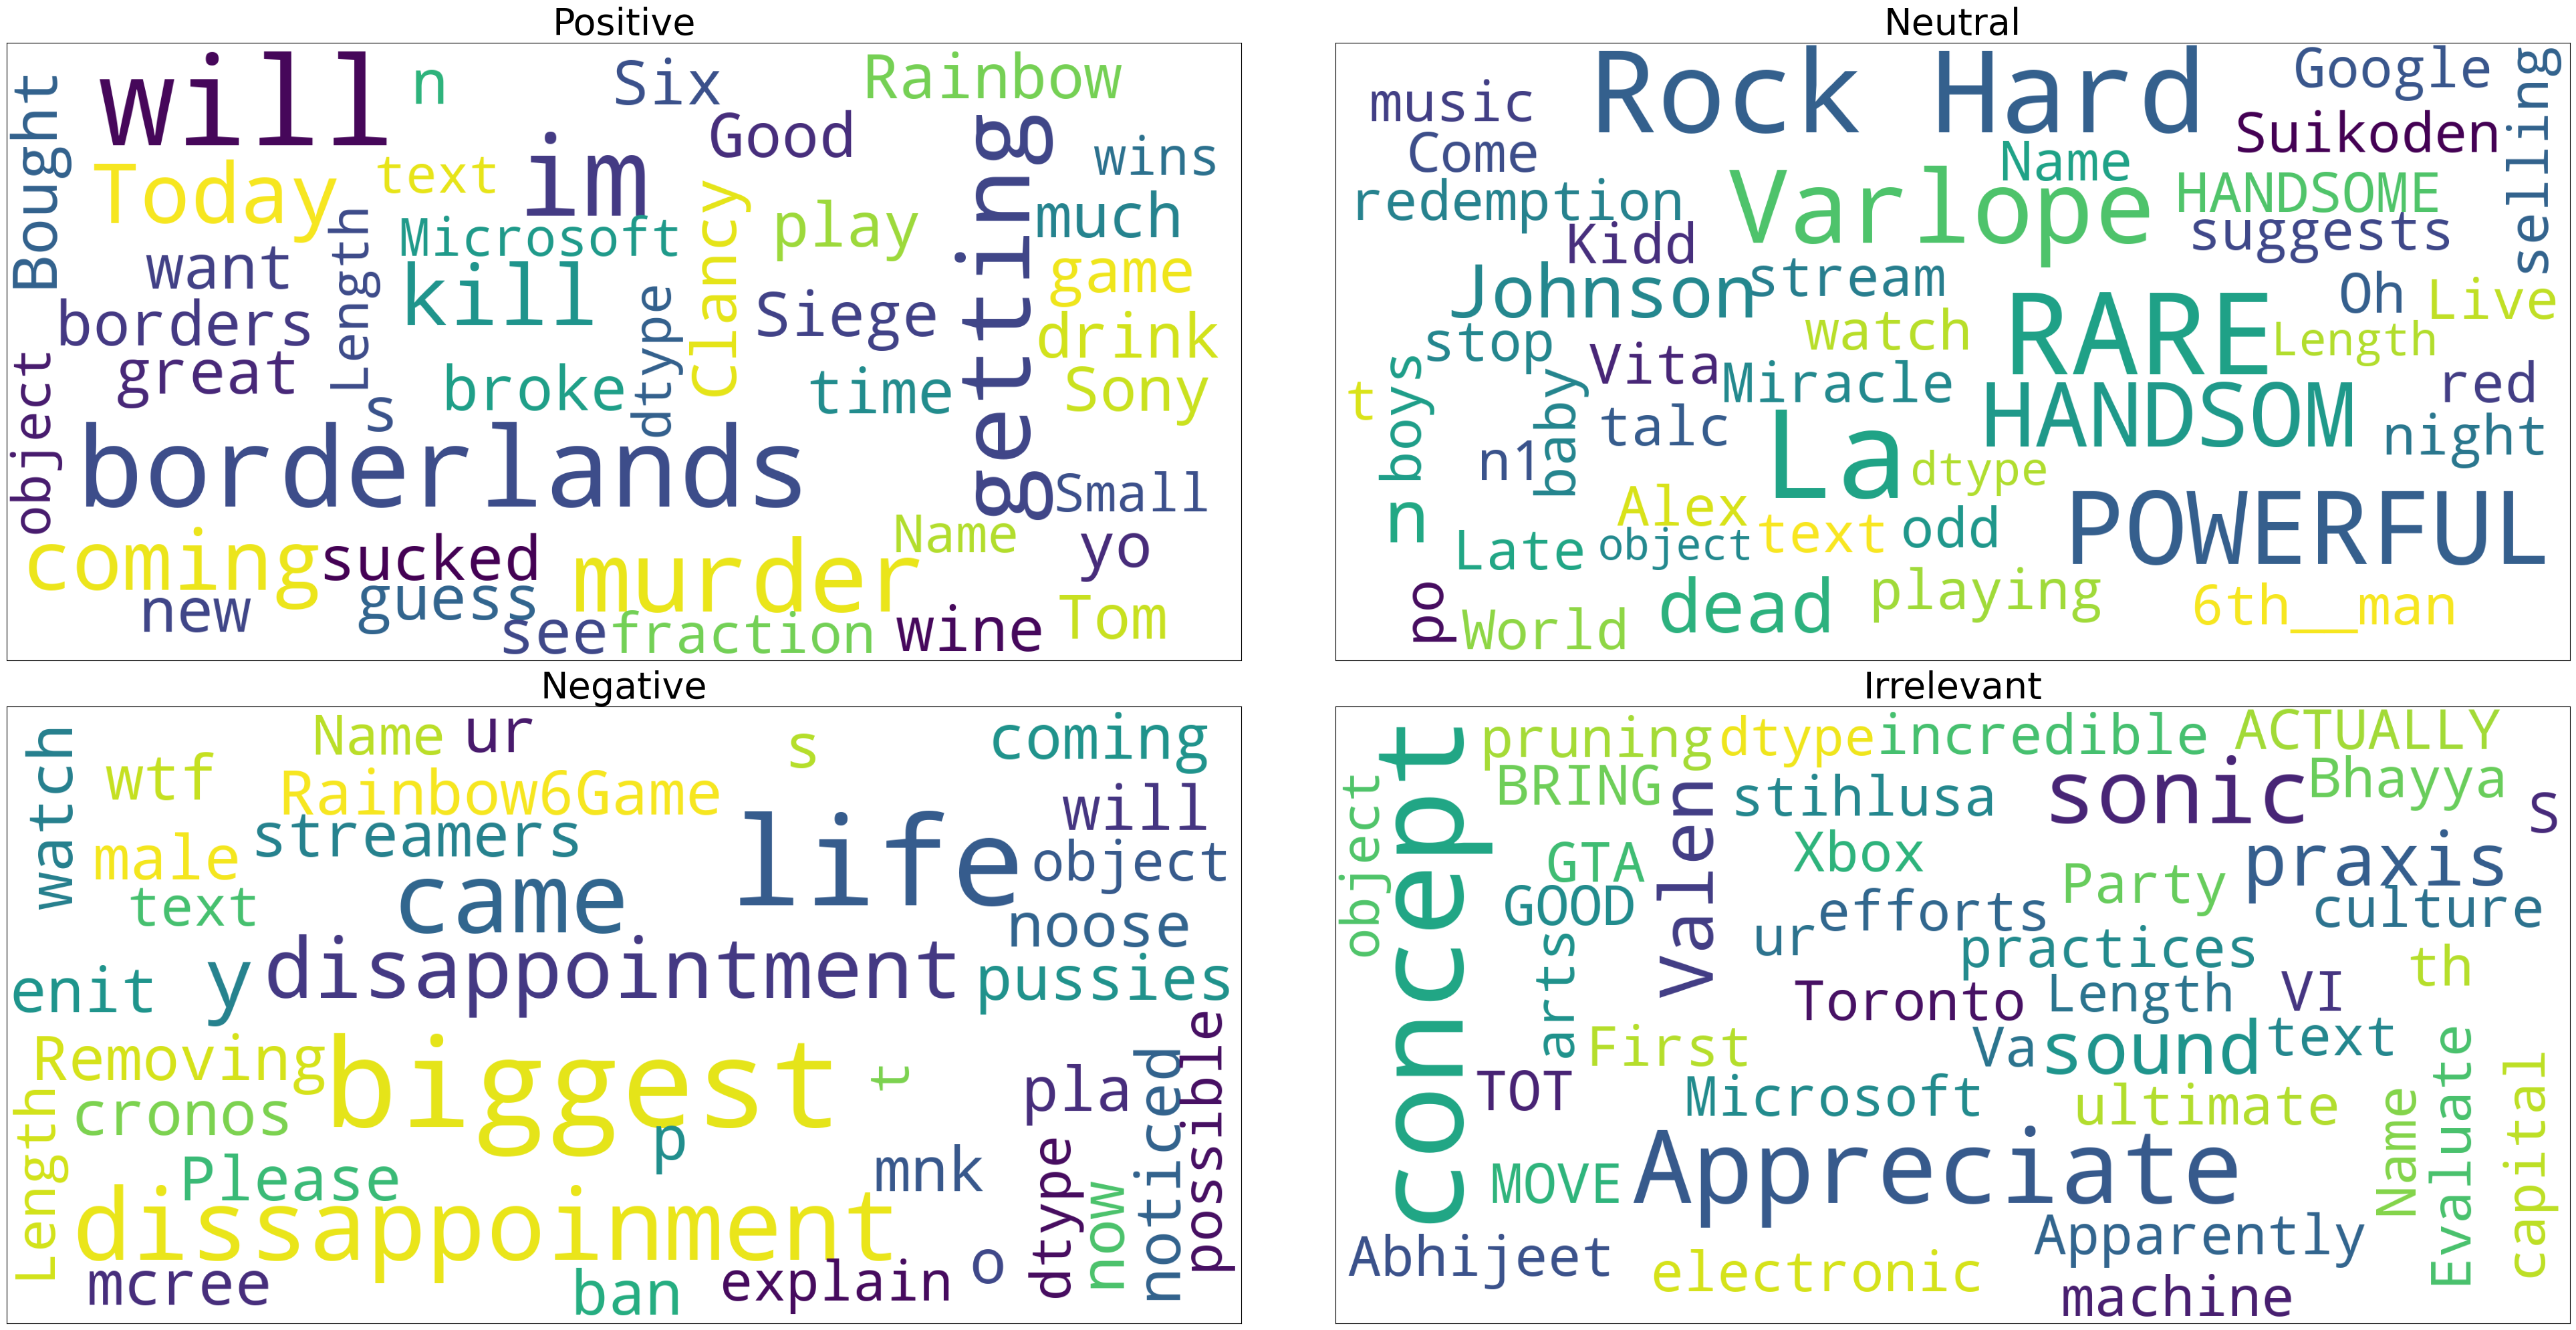

In [16]:
stopwords = set(STOPWORDS)

# plot 2x2 grid word cloud for each sentiment
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)

plt.tight_layout()
plt.show()

In [17]:
# Data Cleaning
# lowercase, remove url, html, punctuations, retweet

df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: ps.remove_urls(x))
df['text'] = df['text'].apply(lambda x: ps.remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))
df['text'] = df['text'].apply(lambda x: ps.remove_rt(x))

# Model Building

In [18]:
X = df['text']
y = df['sentiment']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, X_test.shape

((59717,), (14930,))

In [21]:
stopwords = list(stopwords)

In [22]:
clf = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['of', 'again', 'http', "there's",
                                             'like', 'shall', "they'll",
                                             "haven't", 'who', "we'll", 'your',
                                             'when', 'my', 'after', 'also',
                                             'into', "hasn't", "shan't",
                                             "can't", 'there', 'where', 'about',
                                             'its', 'any', 'have', 'here',
                                             'doing', 'so', 'the', 'yourself', ...])),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [23]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9136637642330877


In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

  Irrelevant       0.96      0.87      0.91      2616
    Negative       0.93      0.93      0.93      4552
     Neutral       0.93      0.89      0.91      3679
    Positive       0.86      0.95      0.90      4083

    accuracy                           0.91     14930
   macro avg       0.92      0.91      0.91     14930
weighted avg       0.92      0.91      0.91     14930



In [25]:
# Save the Model

In [26]:
joblib.dump(clf, 'models/twitter_sentiment.sav', compress=3)

['models/twitter_sentiment.sav']